# Mount to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Sep  3 21:20 .
drwxr-xr-x 1 root root 4096 Sep  3 21:19 ..
drwxr-xr-x 4 root root 4096 Aug 31 13:24 .config
drwx------ 6 root root 4096 Sep  3 21:20 drive
drwxr-xr-x 1 root root 4096 Aug 31 13:25 sample_data


In [3]:
%cd "/content/drive/Othercomputers/isaac_mac_pro/diffusion_model_course/01_week1"
!pwd; ls -la

/content/drive/Othercomputers/isaac_mac_pro/diffusion_model_course/01_week1
/content/drive/Othercomputers/isaac_mac_pro/diffusion_model_course/01_week1
total 1222
-rw------- 1 root root 164451 Sep  3 17:26 Forward-process-improvements.ipynb
-rw------- 1 root root 466903 Sep  3 06:31 Forward-process.ipynb
-rw------- 1 root root 615081 Sep  3 21:20 original_paper_implementation.ipynb
drwx------ 2 root root   4096 Sep  3 06:34 papers


# Import necessary libraries

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
import torch.nn as nn

In [5]:
n_samples = 5000
data, _ = make_swiss_roll(n_samples)
data = data[:, [2, 0]] / 10 # scale data
data = data * np.array([1, -1])

(5000, 2)


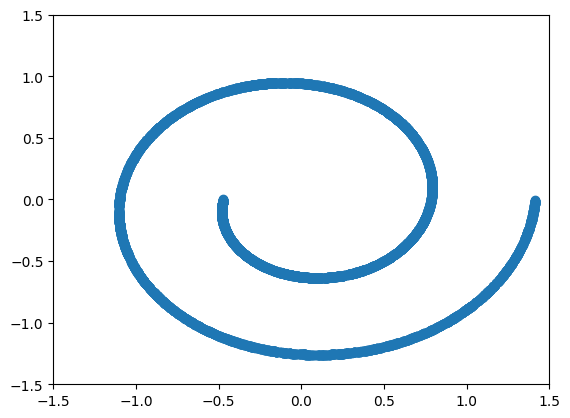

In [6]:
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
print(data.shape)
plt.scatter(data[:, 0], data[:, 1])

# Forward process
The forward trajectory, corresponding to starting at the data distribution and performing $T$ steps of diffusion, is thus
\begin{equation}
q\left(\mathbf{x}^{(0 \cdots T)}\right)=q\left(\mathbf{x}^{(0)}\right) \prod_{t=1}^T q\left(\mathbf{x}^{(t)} \mid \mathbf{x}^{(t-1)}\right)
\end{equation}

Using a guassian kernel, we can express as follow:

\begin{equation}
q\left(\mathbf{x}^{(t)} \mid \mathbf{x}^{(t-1)}\right)= N \left(\mathbf{x}^{(t)} ; \mathbf{x}^{(t-1)} \sqrt{1-\beta_t}, \mathbf{I} \beta_t\right)
\end{equation}

where $N$ is a gaussian distribution with mean μ and covariance Σ.

In [5]:
def forward_process(data, T, betas):

  for i in range(0, T):
    # diffusion rate
    beta_t = betas[i]
    mu = data * torch.sqrt(1 - beta_t)
    std = torch.sqrt(beta_t) # covariance to a std
    # sample from q(x_t | x_{t-1})
    data = mu + torch.randn_like(data) * std # data ~ N(mu, std)
  return data

In [6]:
T = 40
betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
xT = forward_process(torch.from_numpy(data), T, betas)
print(xT.shape)

NameError: ignored

In [ ]:
print(xT.mean(0))
print(xT.std(0))


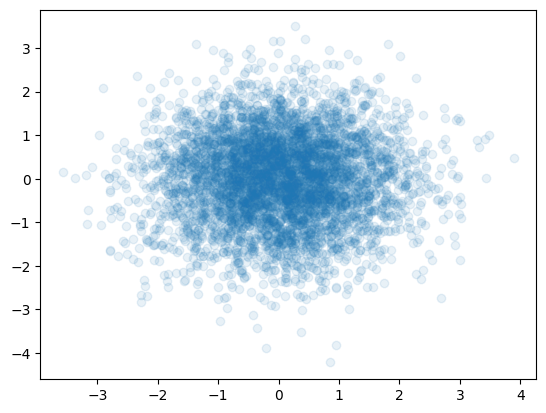

In [10]:
plt.scatter(xT[:, 0].data.numpy(), xT[:, 1].data.numpy(), alpha = 0.1)

# Analytical solution of diffusion

Since $q\left(\mathbf{x}^{(t)} \mid \mathbf{x}^{(t-1)}\right)$ is assumed to be gaussian, we can directly compute q in closed-form:

\begin{equation}
\mathbf{x}^{(t)}=\prod_{i=1}^t \sqrt{1-\beta_i} \mathbf{x}^{(0)}+\sqrt{1-\prod_{i=1}^t\left(1-\beta_i\right) \epsilon}
\end{equation}

let us define $\alpha_t=1-\beta_t$ and $\bar{a}_t=\prod_{i=1}^t \alpha_i$,

$\mathbf{x}^{(t)}=\sqrt{\bar{\alpha}_t} \mathbf{x}^{(0)}+\sqrt{1-\bar{\alpha}_t} \epsilon ; \quad \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

In [10]:
class DiffusionModel():
  def __init__(self, T, model: nn.Module):
    self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
    self.alphas = 1. - self.betas
    self.alphas_bar = torch.cumprod(self.alphas, 0)
    self.T = T
    self.model = model

  def forward_process(self, x0, t = 40):
    """
      diffuse to the targeted well-behaved distribution following its analytical form and assuming the
      distribution being gaussian.
    """
    assert t > 0, "t = {}. invalid t".format(str(t))
    t = t - 1
    mu = x0 * torch.sqrt(self.alphas_bar[t])
    std = torch.sqrt(1. - self.alphas_bar[t]) # covariance to a std
    # sample from q(x_t | x_{t-1})
    data = mu + torch.randn_like(x0) * std # data ~ N(mu, std)
    return data

  def reverse_process(self, xt, t):
    """
      reverse the gaussian process by assuming the conditional model as a
      gaussian distribution parameterized by unknown mean and variances
      : param t: number of diffusion steps
    """
    assert t > 0, 't should be positive'
    assert T <= self.T, f't should be smaller than {self.T}'
    t = t - 1 # because we start indexing at 0
    mu, std = self.model(xt, t)
    epsilon = torch.randn_like(x0) # sampling

    return mu + epsilon * std # data ~ N(mu, std)




In [8]:
diff_model = DiffusionModel(40)
xT = diff_model.forward_process(torch.from_numpy(data), 20)

TypeError: ignored

In [9]:
print(xT.mean(0))
print(xT.std(0))


NameError: ignored

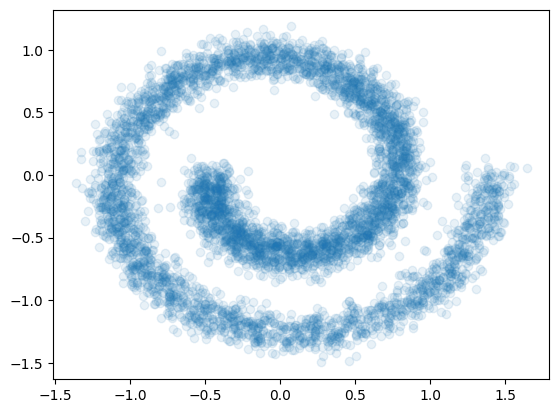

In [14]:
plt.scatter(xT[:, 0].data.numpy(), xT[:, 1].data.numpy(), alpha = 0.1)

## Diffusion process: visualization

In [24]:
def sample_batch(batch_size, scale_factor = 10, device = 'cpu'):
  """
  This function allows for cleaner data handling.
  """

  data, _ = make_swiss_roll(batch_size)
  data = data[:, [2, 0]] / scale_factor
  data = data * np.array([1, -1])
  return torch.from_numpy(data).to(device)

In [28]:
x0 = sample_batch(3000)
diff_model = DiffusionModel(40)
xT = diff_model.forward_process(x0, 20)

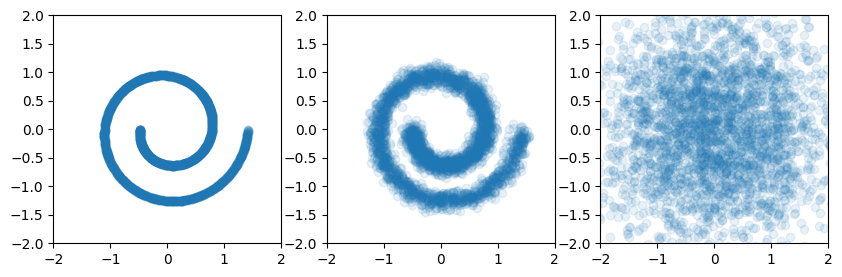

In [30]:
fig = plt.figure(figsize = (10, 3))
data = [x0, diff_model.forward_process(x0, 20), diff_model.forward_process(x0, 40)]

for i in range(3):
  plt.subplot(1, 3, 1 + i)
  plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha = 0.1)
  plt.xlim([-2, 2])
  plt.ylim([-2, 2])
  plt.gca().set_aspect('equal')

# Reverse process

the generative distribution will be trained to describe the same trajectory, but in reverse:

$$
\begin{equation}
p\left(\mathbf{x}^{(T)}\right)=\pi\left(\mathbf{x}^{(T)}\right)
\end{equation}
$$

$$
\begin{equation}p\left(\mathbf{x}^{(0 \cdots T)}\right)=p\left(\mathbf{x}^{(T)}\right) \prod_{t=1}^T p\left(\mathbf{x}^{(t-1)} \mid \mathbf{x}^{(t)}\right)\end{equation}
$$

where $\pi\left(\mathbf{x}^{(T)}\right)$ is a well-behaved distributions.

The conditional probability $p()$, however, does not have a functional form. It is assumed to be a gaussian distribution with unknown mean and vairances, which are trained to match the data, thus yielding a fitted value. This assumption is only justified if the diffusion timestep is small.

In [11]:
class MLP(nn.Module):
  def __init__(self, N = 40, data_dim = 2, hidden_dim = 64):
    super(MLP, self).__init__()

    self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                      nn.ReLU(),
                                      nn.Linear(hidden_dim, hidden_dim),
                                      nn.ReLU())

    self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                        nn.ReLU(),
                                        nn.Linear(hidden_dim, data_dim * 2)) for t in range(N)])

  def forward(self, x, t):
    h = self.network_head(x)  # [batch_size, hidden_dim]
    tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
    mu, h = torch.chunk(tmp, 2, dim = 1)
    var = torch.exp(h)
    std = torch.sqrt(var)

    return mu, std


In [12]:
model = MLP()
t = 5
x = torch.randn((64, 2))
mu, std = model(x, t)
print(mu.shape)
print(std.shape)

torch.Size([64, 2])
torch.Size([64, 2])
